In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Load Dataset

In [ ]:
df = pd.read_excel('Online Retail.xlsx')
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df = df.dropna(subset=['CustomerID'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


 Tujuan: Membaca data penjualan dan membersihkannya.

 Menghapus transaksi dengan kuantitas/harga negatif dan data tanpa CustomerID.

 Menambahkan kolom TotalAmount sebagai hasil dari kuantitas × harga satuan.

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# EDA

In [ ]:
# 1. Info Umum
print("Dimensi Data:", df.shape)
print("\nTipe Data per Kolom:")
print(df.dtypes)
print("\nJumlah Nilai Kosong:")
print(df.isnull().sum())
print("\nJumlah Duplikat:", df.duplicated().sum())
print("\nCustomer ID unik:", df['CustomerID'].nunique())
print("\nJumlah Negara:", df['Country'].nunique())
print("\nPeriode Transaksi:", df['InvoiceDate'].min(), "hingga", df['InvoiceDate'].max())

Dimensi Data: (397884, 9)

Tipe Data per Kolom:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalAmount           float64
dtype: object

Jumlah Nilai Kosong:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalAmount    0
dtype: int64

Jumlah Duplikat: 5192

Customer ID unik: 4338

Jumlah Negara: 37

Periode Transaksi: 2010-12-01 08:26:00 hingga 2011-12-09 12:50:00


In [ ]:
# 2. Statistik Numerik
print("\nStatistik Numerik:")
print(df[['Quantity', 'UnitPrice']].describe())


Statistik Numerik:
            Quantity      UnitPrice
count  397884.000000  397884.000000
mean       12.988238       3.116488
std       179.331775      22.097877
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000


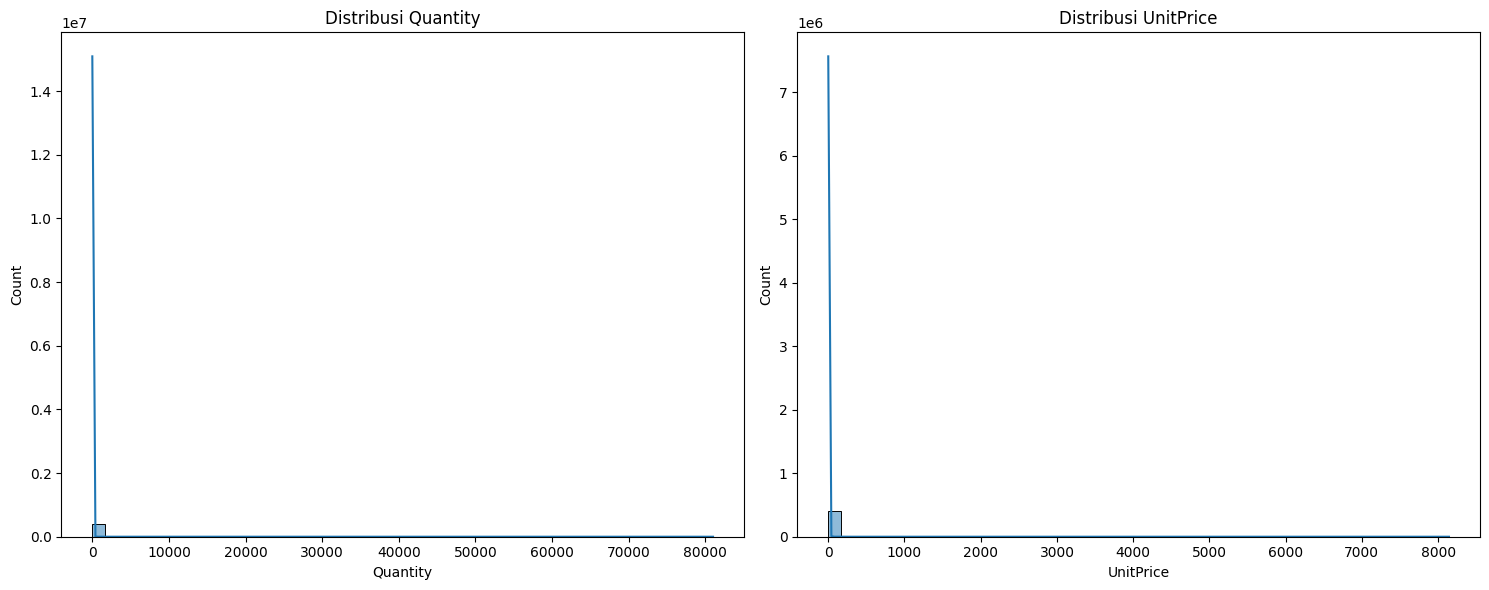

In [ ]:
# 3. Visualisasi Distribusi Quantity & UnitPrice
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title("Distribusi Quantity")
plt.subplot(1, 2, 2)
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title("Distribusi UnitPrice")
plt.tight_layout()
plt.show()

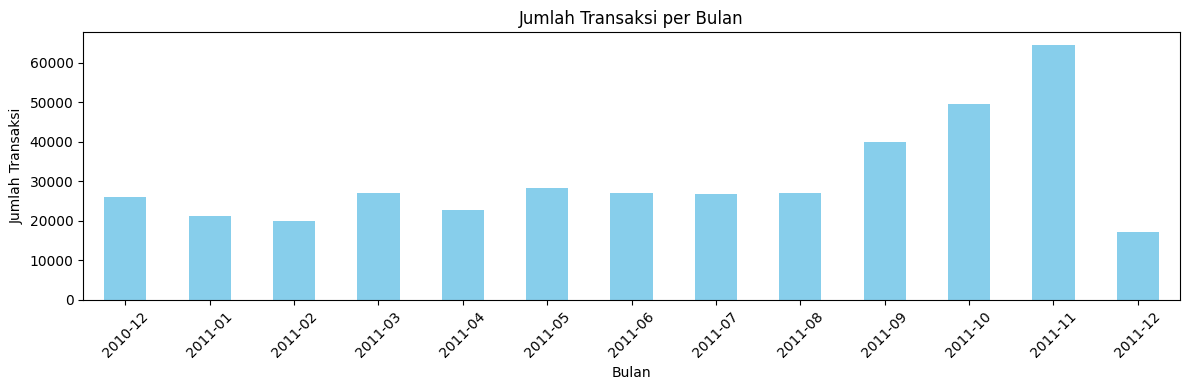

In [ ]:
# 4. Jumlah Transaksi per Bulan
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
transaksi_per_bulan = df.groupby('InvoiceMonth').size()
transaksi_per_bulan.plot(kind='bar', figsize=(12,4), color='skyblue')
plt.title("Jumlah Transaksi per Bulan")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Transaksi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-13-3920700401.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_country.index, y=top_country.values, palette='Set2')


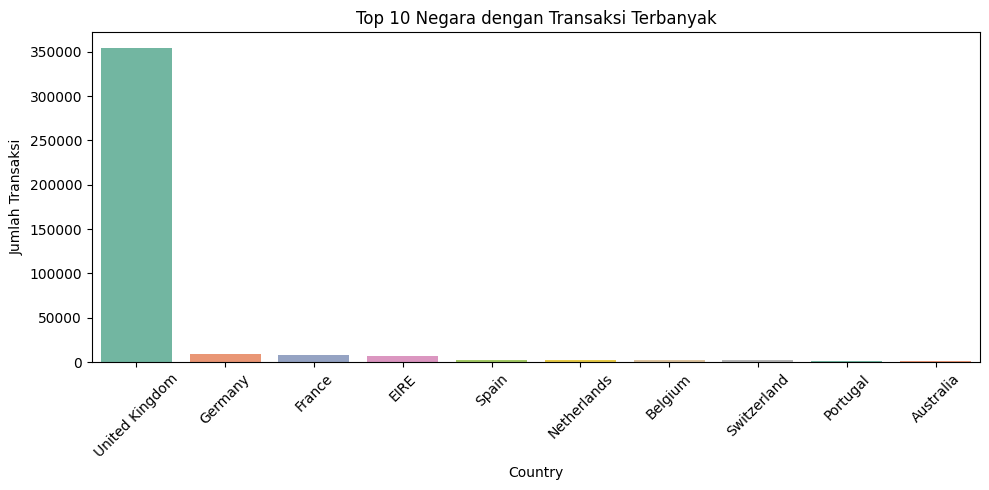

In [ ]:
# 5. Top 10 Negara dengan Transaksi Terbanyak
plt.figure(figsize=(10,5))
top_country = df['Country'].value_counts().head(10)
sns.barplot(x=top_country.index, y=top_country.values, palette='Set2')
plt.title("Top 10 Negara dengan Transaksi Terbanyak")
plt.ylabel("Jumlah Transaksi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Hitung RFM (Recency, Frequency, Monetary)

In [ ]:
snapshot = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

Tujuan: Menghitung nilai RFM untuk setiap pelanggan.

Recency: Hari sejak transaksi terakhir.

Frequency: Jumlah transaksi unik.

Monetary: Total pembelanjaan.

# Transformasi dan Normalisasi

In [ ]:
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

Tujuan:

Melakukan transformasi log untuk mengurangi skewness (data tidak simetris).

Menormalisasi data agar semua fitur berada dalam skala yang sama.

# Elbow dan Silhouette Method

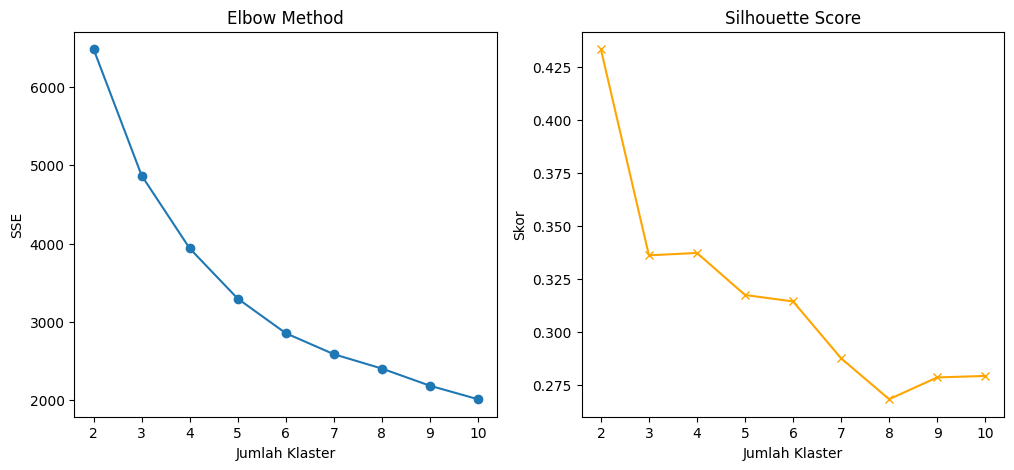

In [ ]:
sse, silhouette = [], []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, kmeans.labels_))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Klaster')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(K, silhouette, marker='x', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Skor')
plt.show()

Tujuan: Mencari jumlah klaster optimal dengan dua metrik:

SSE (Elbow Method): Mengukur seberapa baik klaster memadat (semakin kecil semakin baik).

Silhouette Score: Menilai seberapa baik objek cocok dengan klasternya dibandingkan klaster lain.

# K-Means Clustering (k=4)

In [ ]:
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42).fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

Tujuan: Menjalankan algoritma K-Means dengan jumlah klaster k=4 (misalnya berdasarkan grafik).

Hasil label klaster disimpan ke kolom Cluster.

# Visualisasi dengan PCA

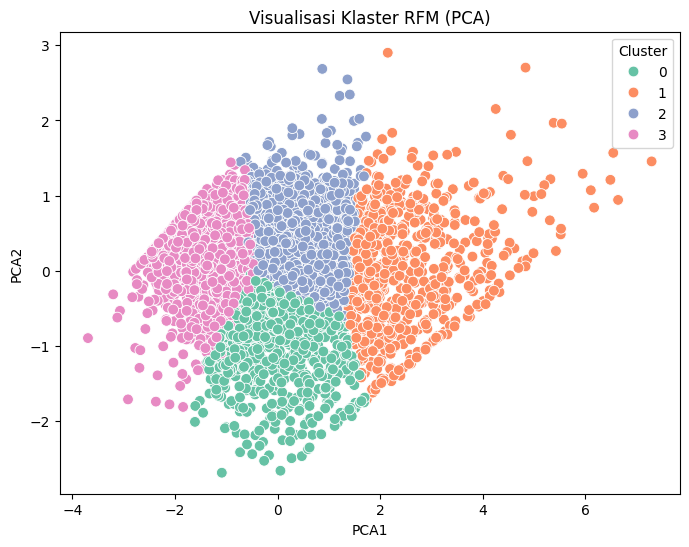

In [ ]:
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_comp[:,0]
rfm['PCA2'] = pca_comp[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title('Visualisasi Klaster RFM (PCA)')
plt.show()

Tujuan: Mengurangi dimensi data menjadi 2D agar bisa divisualisasikan.

# statistik Rata-Rata RFM per Klaster

In [ ]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,18.124253,2.148148,551.819534
1,12.131285,13.713687,8074.266872
2,71.084399,4.083546,1802.829005
3,182.496898,1.318238,343.450032


Tujuan: Melihat karakteristik tiap klaster:

Klaster dengan Recency rendah = pelanggan terbaru.

Klaster dengan Frequency dan Monetary tinggi = pelanggan paling loyal dan bernilai tinggi.

In [ ]:
rfm.to_excel('Dataset_Final_RFM.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('Dataset_Final_RFM.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2
0,12346.0,326,1,77183.60,2,0.872658,2.686758
1,12347.0,2,7,4310.00,1,2.550260,-0.804427
2,12348.0,75,4,1797.24,2,0.475142,0.746121
3,12349.0,19,1,1757.55,0,0.145832,-0.460480
4,12350.0,310,1,334.40,3,-1.688990,0.676555
